In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
import numpy as np
from tqdm import tqdm
from Models.AutoEncoder import AutoEncoder, AE_validDataset, AE_trainDataset
from Models.DAGMM import *
from utils.utils import process_data
from utils.Visualization import plot_confusion_heatmap

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
num_epochs = 100
batch_size = 128
lr = 1e-4
encoding_dim = 28
n_gmm = 2
lambda_energy = 0.1
lambda_cov_diag = 0.005
l1_lambda = 1e-5

In [4]:
# Feature Selection
cat_features = ['Card', 'Gender', 'Card Brand', 'Card Type', 'Expires', 'Has Chip',
                'Year PIN last Changed', 'Whether Security Chip is Used', 'Day']
num_features = ['Current Age', 'Retirement Age', 'Per Capita Income - Zipcode',
                'Yearly Income', 'Total Debt', 'Credit Score', 'Credit Limit', 'Amount']
discarded = ['User', 'Birth Year', 'Birth Month', 'Zipcode']

print(len(cat_features))
print(len(num_features))
print(len(discarded))
print(len(cat_features)*5 + len(num_features))

9
8
4
53


In [5]:

# 데이터 전처리
data_path = '../data/[24-2 DS_Project2] Data.csv'
(train_cat_X, train_num_X, train_y), (valid_cat_X, valid_num_X, valid_y), label_encoders, _ = process_data(
    data_path,
    cat_features,
    num_features,
    discarded
)

TRANSITION
IQR
SPLIT
DISCARD
SCALE
ENCODE
UNLABEL
TARGET
TRAIN CAT/NUM
VALID CAT/NUM
RETURN


In [16]:
print(train_y.value_counts())
print(valid_y.value_counts())

Is Fraud?
0.0          902733
Name: count, dtype: int64
Is Fraud?
0.0          308750
1.0             494
Name: count, dtype: int64


In [14]:
train_dataset = AE_trainDataset(train_cat_X, train_num_X, device)
valid_dataset = AE_validDataset(valid_cat_X, valid_num_X, valid_y, device)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [15]:
%load_ext autoreload
%autoreload 2
from Models.DAGMM import DAGMM

model = DAGMM(
    encoding_dim=encoding_dim,
    n_gmm=n_gmm,
    cat_features=cat_features,
    num_features=num_features,
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.MSELoss()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
for epoch in range(num_epochs):
    for cat_features, num_features in tqdm(train_loader):
        cat_features = cat_features.to(device)
        num_features = num_features.to(device)

        # dagmm_step
        model.train()
        enc, dec, z, gamma = model(cat_features, num_features)

        cat_embedding = model.get_embedding_cat(cat_features)
        total_loss, recon_loss, energy, cov_diag = model.loss(
            torch.cat(cat_embedding +  [num_features], dim=1), dec, z, gamma, lambda_energy, lambda_cov_diag
        )

        model.zero_grad()
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        #logging
        loss = {}
        loss['total_loss'] = total_loss.data.item()
        loss['sample_energy'] = recon_loss.item()
        loss['recon_loss'] = recon_loss.item()
        loss['cov_diag'] = cov_diag.item()



In [21]:
# Training Loop
best_f1 = 0
for epoch in range(num_epochs):
    # Training Phase
    #model.train()
    train_loss = 0
    for cat_features, num_features in tqdm(train_loader):
        cat_features = cat_features.to(device)
        num_features = num_features.to(device)
        #optimizer.zero_grad()
        #print(cat_features.shape)
        #enc, dec, z, gamma = model(cat_features, num_features)
        #cat_embedding = model.get_embedding_cat(cat_features)
        #loss, recon_loss, energy_loss, cov_diag_loss = model.loss(
        #    torch.cat(cat_embedding +  [num_features], dim=1), dec, z, gamma, lambda_energy, lambda_cov_diag
        #)
        #loss = loss.mean()
        #loss.backward()
        #optimizer.step()

        # dagmm_step
        model.train()
        enc, dec, z, gamma = model(cat_features, num_features)

        cat_embedding = model.get_embedding_cat(cat_features)
        loss, recon_loss, energy, cov_diag = model.loss(
            torch.cat(cat_embedding +  [num_features], dim=1), dec, z, gamma, lambda_energy, lambda_cov_diag
        )

        model.zero_grad()
        loss = loss.mean()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation Phase (every 10 epochs)
    if epoch % 10 == 0:
        model.eval()
        valid_loss = 0
        reconstruction_errors = []
        all_labels = []
        total_recon_loss = 0  # Validation 복원 손실
        total_energy_loss = 0  # Validation 에너지 손실

        with torch.no_grad():
            for cat_features, num_features, labels in valid_loader:
                cat_features = cat_features.to(device)
                num_features = num_features.to(device)
                labels = labels.to(device)

                enc, dec, z, gamma = model(cat_features, num_features)

                # Validation 손실 계산
                cat_embedding = model.get_embedding_cat(cat_features)
                loss, recon_loss, energy_loss, cov_diag_loss = model.loss(
                    torch.cat(cat_embedding + [num_features], dim=1), dec, z, gamma, lambda_energy, lambda_cov_diag
                )
                valid_loss += loss.mean().item()  # 총 Validation 손실 계산
                total_recon_loss += recon_loss.mean().item()
                total_energy_loss += energy_loss.mean().item()

                sample_errors = model.compute_energy(z, model.phi, model.mu, model.cov)
                reconstruction_errors.extend(sample_errors.cpu().numpy())

                all_labels.extend(labels.cpu().numpy())

        # 손실 평균 계산
        valid_loss /= len(valid_loader)
        total_recon_loss /= len(valid_loader)
        total_energy_loss /= len(valid_loader)

        # Performance Evaluation
        threshold = np.percentile(reconstruction_errors, 50)
        print(reconstruction_errors)
        predictions = (np.array(reconstruction_errors) > threshold).astype(int)
        f1 = f1_score(all_labels, predictions)
        recall = recall_score(all_labels, predictions)
        precision = precision_score(all_labels, predictions, zero_division=1)

        # 결과 출력
        print(f"Epoch {epoch}:")
        print(f"  Train Loss     = {train_loss:.4f}")
        print(f"  Valid Loss     = {valid_loss:.4f}")
        print(f"  Recon Loss     = {total_recon_loss:.4f}")
        print(f"  Energy Loss    = {total_energy_loss:.4f}")
        print(f"  Valid F1 Score = {f1:.4f}")
        print(f"  Valid Recall   = {recall:.4f}")
        print(f"  Valid Precision= {precision:.4f}")

        # Save Best Model
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_model.pth')

print(f"Best F1 Score: {best_f1}")

100%|██████████| 7053/7053 [00:57<00:00, 122.11it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 0:
  Train Loss     = 1.1930
  Valid Loss     = 1.2231
  Recon Loss     = 0.0044
  Energy Loss    = 12.1868
  Valid F1 Score = 0.0032
  Valid Recall   = 0.3543
  Valid Precision= 0.0016


100%|██████████| 7053/7053 [00:58<00:00, 119.97it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 10:
  Train Loss     = 1.1909
  Valid Loss     = 1.2233
  Recon Loss     = 0.0045
  Energy Loss    = 12.1884
  Valid F1 Score = 0.0034
  Valid Recall   = 0.3482
  Valid Precision= 0.0017


100%|██████████| 7053/7053 [01:00<00:00, 116.93it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 20:
  Train Loss     = 1.1893
  Valid Loss     = 1.2251
  Recon Loss     = 0.0074
  Energy Loss    = 12.1774
  Valid F1 Score = 0.0029
  Valid Recall   = 0.4595
  Valid Precision= 0.0015


100%|██████████| 7053/7053 [00:59<00:00, 117.91it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 30:
  Train Loss     = 1.1865
  Valid Loss     = 1.2228
  Recon Loss     = 0.0049
  Energy Loss    = 12.1798
  Valid F1 Score = 0.0030
  Valid Recall   = 0.4676
  Valid Precision= 0.0015


100%|██████████| 7053/7053 [00:54<00:00, 128.25it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 40:
  Train Loss     = 1.1863
  Valid Loss     = 1.2222
  Recon Loss     = 0.0044
  Energy Loss    = 12.1771
  Valid F1 Score = 0.0031
  Valid Recall   = 0.4899
  Valid Precision= 0.0016


100%|██████████| 7053/7053 [00:57<00:00, 123.56it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 50:
  Train Loss     = 1.1862
  Valid Loss     = 1.2265
  Recon Loss     = 0.0092
  Energy Loss    = 12.1733
  Valid F1 Score = 0.0029
  Valid Recall   = 0.4494
  Valid Precision= 0.0014


100%|██████████| 7053/7053 [01:01<00:00, 114.37it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 60:
  Train Loss     = 1.1861
  Valid Loss     = 1.2241
  Recon Loss     = 0.0071
  Energy Loss    = 12.1693
  Valid F1 Score = 0.0034
  Valid Recall   = 0.5385
  Valid Precision= 0.0017


100%|██████████| 7053/7053 [00:59<00:00, 119.32it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 70:
  Train Loss     = 1.1860
  Valid Loss     = 1.2210
  Recon Loss     = 0.0044
  Energy Loss    = 12.1666
  Valid F1 Score = 0.0031
  Valid Recall   = 0.4879
  Valid Precision= 0.0016


100%|██████████| 7053/7053 [01:01<00:00, 114.67it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 80:
  Train Loss     = 1.1859
  Valid Loss     = 1.2226
  Recon Loss     = 0.0061
  Energy Loss    = 12.1650
  Valid F1 Score = 0.0034
  Valid Recall   = 0.5304
  Valid Precision= 0.0017


100%|██████████| 7053/7053 [00:58<00:00, 119.75it/s]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




Epoch 90:
  Train Loss     = 1.1858
  Valid Loss     = 1.2215
  Recon Loss     = 0.0050
  Energy Loss    = 12.1644
  Valid F1 Score = 0.0034
  Valid Recall   = 0.5263
  Valid Precision= 0.0017


100%|██████████| 7053/7053 [00:57<00:00, 122.05it/s]


Best F1 Score: 0.0034298018838122375


In [22]:
model.eval()
valid_loss = 0
reconstruction_errors = []
all_labels = []
total_recon_loss = 0  # Validation 복원 손실
total_energy_loss = 0  # Validation 에너지 손실

with torch.no_grad():
    for cat_features, num_features, labels in valid_loader:
        cat_features = cat_features.to(device)
        num_features = num_features.to(device)
        labels = labels.to(device)

        enc, dec, z, gamma = model(cat_features, num_features)

        # Validation 손실 계산
        cat_embedding = model.get_embedding_cat(cat_features)
        loss, recon_loss, energy_loss, cov_diag_loss = model.loss(
            torch.cat(cat_embedding + [num_features], dim=1), dec, z, gamma, lambda_energy, lambda_cov_diag
        )
        valid_loss += loss.mean().item()  # 총 Validation 손실 계산
        total_recon_loss += recon_loss.mean().item()
        total_energy_loss += energy_loss.mean().item()

        sample_errors = model.compute_energy(z, model.phi, model.mu, model.cov)
        reconstruction_errors.extend(sample_errors.cpu().numpy())

        all_labels.extend(labels.cpu().numpy())

# 손실 평균 계산
valid_loss /= len(valid_loader)
total_recon_loss /= len(valid_loader)
total_energy_loss /= len(valid_loader)

# Performance Evaluation
threshold = np.percentile(reconstruction_errors, 50)
print(reconstruction_errors)
predictions = (np.array(reconstruction_errors) > threshold).astype(int)
f1 = f1_score(all_labels, predictions)
recall = recall_score(all_labels, predictions)
precision = precision_score(all_labels, predictions, zero_division=1)

# 결과 출력
print(f"  Valid Loss     = {valid_loss:.4f}")
print(f"  Recon Loss     = {total_recon_loss:.4f}")
print(f"  Energy Loss    = {total_energy_loss:.4f}")
print(f"  Valid F1 Score = {f1:.4f}")
print(f"  Valid Recall   = {recall:.4f}")
print(f"  Valid Precision= {precision:.4f}")

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)




  Valid Loss     = 1.2217
  Recon Loss     = 0.0055
  Energy Loss    = 12.1625
  Valid F1 Score = 0.0031
  Valid Recall   = 0.4858
  Valid Precision= 0.0016


Confusion Matrix:
 [[154369 154381]
 [   254    240]]


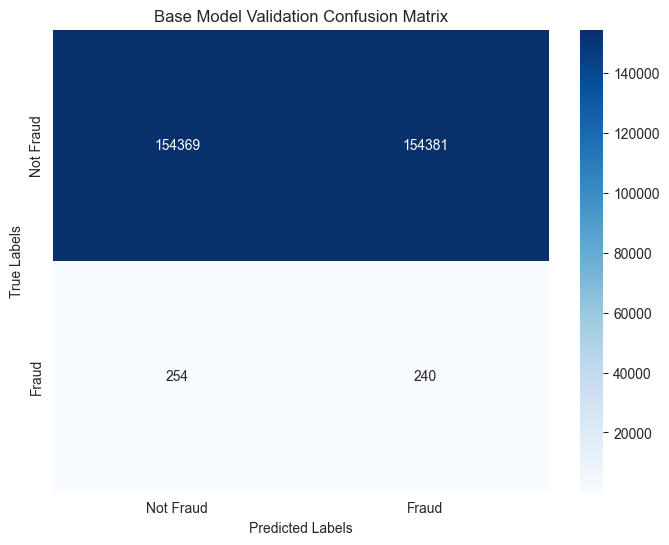

In [29]:
print("Confusion Matrix:\n", confusion_matrix(all_labels, predictions))
plot_confusion_heatmap(
    y_true=all_labels,
    y_pred=predictions,
    class_names=["Not Fraud", "Fraud"],
    title="Base Model Validation Confusion Matrix",
    cmap="Blues"
)